# Assignment 5

In [49]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
%reload_ext autoreload
%autoreload 1
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth',100)    

display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from itertools import combinations, takewhile
import collections

from simhash import Simhash, SimhashIndex

sns.set()

print(sys.version)

3.6.8 |Anaconda custom (64-bit)| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


In [3]:
print(spark.version)

2.4.0-cdh6.1.0


In [4]:
import pandas as pd
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
# from pyspark.ml.feature import OneHotEncoderEstimator
# OneHotEncoderEstimator is available starting from Spark 2.3
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.functions import *
from pyspark.sql.types import *

In [5]:
!ls -l -h '/project/msca/kadochnikov/webhose/'

total 2.7G
-rwxr-xr-x 1 kadochnikov kadochnikov 6.0M Nov  7 21:07 news_apple_fruit_2018_10.gz
-rwxr-xr-x 1 kadochnikov kadochnikov  22M Nov  7 20:53 news_apple_fruit_2018_10.json
-rwxr-xr-x 1 kadochnikov kadochnikov  44M Sep 23 12:21 news_autos_2018_09.gz
-rwxr-xr-x 1 kadochnikov kadochnikov 169M Sep 23 12:13 news_autos_2018_09.json
-rwxr-xr-x 1 kadochnikov kadochnikov  51M Feb 20  2018 news_chicago_il_2018_02.gz
-rwxr-xr-x 1 kadochnikov kadochnikov 194M Feb 20  2018 news_chicago_il_2018_02.json
-rwxr-xr-x 1 kadochnikov kadochnikov  54M Sep 23 11:53 news_chicago_il_2018_09.gz
-rwxr-xr-x 1 kadochnikov kadochnikov 205M Sep 23 11:44 news_chicago_il_2018_09.json
-rwxr-xr-x 1 kadochnikov kadochnikov  51M Nov  7 18:31 news_chicago_il_2018_10.gz
-rwxr-xr-x 1 kadochnikov kadochnikov 186M Nov  7 18:27 news_chicago_il_2018_10.json
-rwxr-xr-x 1 kadochnikov kadochnikov 104K Feb 22  2018 news_toyota_aws.json
-rwxr-xr-x 1 kadochnikov kadochnikov  67M Jun  8  2018 news_university_2018_02.gz
-rwxr-xr-

In [6]:
df = spark.read.json('file:///project/msca/kadochnikov/webhose/news_university_2018_02.json')
# df.cache()
df.count()

1

In [7]:
df.printSchema()

root
 |-- author: string (nullable = true)
 |-- crawled: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- locations: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- sentiment: string (nullable = true)
 |    |-- organizations: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- sentiment: string (nullable = true)
 |    |-- persons: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- sentiment: string (nullable = true)
 |-- external_links: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- highlightText: string (nullable = true)
 |-- highlightTitle: string (nullable = true)
 |-- language: string (nullable = true)
 |-- ord_in_thread: long (nullable = 

## Running similarity analysis on "Title"

In [8]:
title_df = df.select('title').toPandas()

In [66]:
print("Number of records :", title_df.shape[0])
title_df.head(20)

Number of records : 57500


,title
0,FREE public planetarium shows at Wayne State University Planetarium - RSVP 1/26 and 2/2
1,A computer Science professor at my university sent this email out
2,Whos the Greatest College Football Team Ever
3,FULL HD VIDEO || ओढ़नी से मुह बाध के || College Me Aabelu || Vivek Dubey ...
4,Tips For Newborn Photography College Station TX
5,How To Prepare For Newborn Photography College Station TX
6,Tips For Getting The Best Outcome With Newborn Photography College Station TX
7,New Headmaster Joins King's College India at the Start of 2018
8,Sunway University Launches Publishing Department
9,Home Recording Studio Essentials for Beginners College Students


In [23]:
data = title_df['title'].to_dict()

#### Finding Near duplicates

In [44]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    max_len = np.maximum(len(s)-width+1, 1)
    return [s[i:i + width] for i in range(max_len)]

Let's fix a feature width and observe how the titles behave.

In [45]:
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]

Let's choose a test string from the set, and check how the algorithm behaves by visualising each cluster.

In [72]:
test_str_list = ["university"]
print("Strings to test against :\n\t", test_str_list)

Strings to test against :
	 ['university']


Iterate through different tolerance values

In [95]:
map_unique_simcount = {}

for test_string in test_str_list:
    print(100*"=")
    print("Testing against string : ", test_string)
#     for tval in [4,8,10,12]:
    for tval in range(1,20):
        print(80*"-")
        print("Tolerance Value under scrutiny : ", tval)
        index = SimhashIndex(objs, k=tval)
        print("Bucket Size :", index.bucket_size())
        # Get the similarity buckets
        s = Simhash(get_features(test_string))
        s_dups = index.get_near_dups(s)
        num_dups = len(s_dups)
        print ("Number of near duplicates :", num_dups)
        
        map_unique_simcount[tval] = {"unique":index.bucket_size(), 
                                     "near_dup_count":num_dups}

#         display(title_df.iloc[s_dups].head(5))

Testing against string :  university
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  1
Bucket Size : 86934
Number of near duplicates : 11
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  2
Bucket Size : 122186
Number of near duplicates : 11
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  3
Bucket Size : 88632
Number of near duplicates : 11
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  4


Big bucket found. key:489:1, len:293
Big bucket found. key:8d6:3, len:372


Bucket Size : 39256
Number of near duplicates : 11
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  5


Big bucket found. key:181:0, len:302
Big bucket found. key:225:1, len:355
Big bucket found. key:4:2, len:541
Big bucket found. key:182:3, len:215
Big bucket found. key:8d:4, len:755


Bucket Size : 17124
Number of near duplicates : 12
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  6


Big bucket found. key:181:0, len:378
Big bucket found. key:4a:1, len:1154
Big bucket found. key:12:2, len:520
Big bucket found. key:10:3, len:255
Big bucket found. key:d6:4, len:2216
Big bucket found. key:1a4:5, len:487
Big bucket found. key:140:6, len:229


Bucket Size : 4096
Number of near duplicates : 13
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  7


Big bucket found. key:81:0, len:646
Big bucket found. key:95:1, len:1453
Big bucket found. key:48:2, len:1011
Big bucket found. key:80:3, len:653
Big bucket found. key:60:4, len:702
Big bucket found. key:8d:5, len:1378
Big bucket found. key:34:6, len:1955
Big bucket found. key:50:7, len:512


Bucket Size : 2048
Number of near duplicates : 16
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  8


Big bucket found. key:1:0, len:1247
Big bucket found. key:2b:1, len:1652
Big bucket found. key:22:2, len:1514
Big bucket found. key:2:3, len:1634
Big bucket found. key:8:4, len:1095
Big bucket found. key:2c:5, len:2460
Big bucket found. key:23:6, len:1611
Big bucket found. key:1a:7, len:2551
Big bucket found. key:50:8, len:512


Bucket Size : 1280
Number of near duplicates : 23
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  9


Big bucket found. key:1:0, len:1524
Big bucket found. key:16:1, len:3205
Big bucket found. key:9:2, len:4170
Big bucket found. key:12:3, len:2133
Big bucket found. key:0:4, len:2434
Big bucket found. key:2:5, len:1120


Bucket Size : 1600


Big bucket found. key:16:6, len:5078
Big bucket found. key:23:7, len:2239
Big bucket found. key:34:8, len:3668
Big bucket found. key:140:9, len:229


Number of near duplicates : 49
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  10


Big bucket found. key:1:0, len:2958
Big bucket found. key:c:1, len:5463
Big bucket found. key:5:2, len:4114
Big bucket found. key:11:3, len:2853
Big bucket found. key:4:4, len:4311


Bucket Size : 12343


Big bucket found. key:0:5, len:5387
Big bucket found. key:2:6, len:2360
Big bucket found. key:c:7, len:4324
Big bucket found. key:d:8, len:9739
Big bucket found. key:4:9, len:2559


Number of near duplicates : 88
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  11


Big bucket found. key:1:0, len:2958
Big bucket found. key:c:1, len:5463
Big bucket found. key:5:2, len:4114
Big bucket found. key:11:3, len:2853
Big bucket found. key:4:4, len:4311


Bucket Size : 864


Big bucket found. key:0:5, len:5387
Big bucket found. key:2:6, len:2360
Big bucket found. key:c:7, len:4324
Big bucket found. key:d:8, len:9739
Big bucket found. key:4:9, len:2559
Big bucket found. key:d:a, len:4025
Big bucket found. key:a0:b, len:427


Number of near duplicates : 159
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  12


Big bucket found. key:1:0, len:4661
Big bucket found. key:8:1, len:7573
Big bucket found. key:5:2, len:7667
Big bucket found. key:9:3, len:7328


Bucket Size : 24348


Big bucket found. key:8:4, len:5132
Big bucket found. key:4:5, len:8859
Big bucket found. key:0:6, len:6771
Big bucket found. key:8:7, len:4153
Big bucket found. key:0:8, len:6102
Big bucket found. key:6:9, len:8438
Big bucket found. key:d:a, len:12226
Big bucket found. key:8:b, len:4498


Number of near duplicates : 268
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  13


Big bucket found. key:1:0, len:4661
Big bucket found. key:8:1, len:7573
Big bucket found. key:5:2, len:7667
Big bucket found. key:9:3, len:7328


Bucket Size : 4210


Big bucket found. key:8:4, len:5132
Big bucket found. key:4:5, len:8859
Big bucket found. key:0:6, len:6771
Big bucket found. key:8:7, len:4153
Big bucket found. key:0:8, len:6102
Big bucket found. key:6:9, len:8438
Big bucket found. key:d:a, len:12226
Big bucket found. key:8:b, len:4498
Big bucket found. key:4:c, len:10808


Number of near duplicates : 448
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  14


Big bucket found. key:1:0, len:4661
Big bucket found. key:8:1, len:7573
Big bucket found. key:5:2, len:7667


Bucket Size : 480


Big bucket found. key:9:3, len:7328
Big bucket found. key:8:4, len:5132
Big bucket found. key:4:5, len:8859
Big bucket found. key:0:6, len:6771
Big bucket found. key:8:7, len:4153
Big bucket found. key:0:8, len:6102
Big bucket found. key:6:9, len:8438
Big bucket found. key:d:a, len:12226
Big bucket found. key:8:b, len:4498
Big bucket found. key:4:c, len:10808
Big bucket found. key:3:d, len:7596
Big bucket found. key:50:e, len:512


Number of near duplicates : 950
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  15


Big bucket found. key:1:0, len:4661
Big bucket found. key:8:1, len:7573
Big bucket found. key:5:2, len:7667


Bucket Size : 256


Big bucket found. key:9:3, len:7328
Big bucket found. key:8:4, len:5132
Big bucket found. key:4:5, len:8859
Big bucket found. key:0:6, len:6771
Big bucket found. key:8:7, len:4153
Big bucket found. key:0:8, len:6102
Big bucket found. key:6:9, len:8438
Big bucket found. key:d:a, len:12226
Big bucket found. key:8:b, len:4498
Big bucket found. key:4:c, len:10808
Big bucket found. key:3:d, len:7596
Big bucket found. key:0:e, len:4175
Big bucket found. key:5:f, len:4211


Number of near duplicates : 1419
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  16


Big bucket found. key:1:0, len:8581
Big bucket found. key:0:1, len:10758
Big bucket found. key:6:2, len:12045


Bucket Size : 24284


Big bucket found. key:2:3, len:13079
Big bucket found. key:1:4, len:12334
Big bucket found. key:1:5, len:12464
Big bucket found. key:2:6, len:8327
Big bucket found. key:2:7, len:12446
Big bucket found. key:0:8, len:11984
Big bucket found. key:0:9, len:12350
Big bucket found. key:2:a, len:7759
Big bucket found. key:0:b, len:9276
Big bucket found. key:6:c, len:10860
Big bucket found. key:2:d, len:18569
Big bucket found. key:3:e, len:18744
Big bucket found. key:4:f, len:5585


Number of near duplicates : 2455
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  17


Big bucket found. key:1:0, len:8581
Big bucket found. key:0:1, len:10758
Big bucket found. key:6:2, len:12045


Bucket Size : 7454


Big bucket found. key:2:3, len:13079
Big bucket found. key:1:4, len:12334
Big bucket found. key:1:5, len:12464
Big bucket found. key:2:6, len:8327
Big bucket found. key:2:7, len:12446
Big bucket found. key:0:8, len:11984
Big bucket found. key:0:9, len:12350
Big bucket found. key:2:a, len:7759
Big bucket found. key:0:b, len:9276
Big bucket found. key:6:c, len:10860
Big bucket found. key:2:d, len:18569
Big bucket found. key:3:e, len:18744
Big bucket found. key:4:f, len:5585
Big bucket found. key:4:10, len:16139


Number of near duplicates : 3355
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  18


Big bucket found. key:1:0, len:8581
Big bucket found. key:0:1, len:10758
Big bucket found. key:6:2, len:12045


Bucket Size : 1168


Big bucket found. key:2:3, len:13079
Big bucket found. key:1:4, len:12334
Big bucket found. key:1:5, len:12464
Big bucket found. key:2:6, len:8327
Big bucket found. key:2:7, len:12446
Big bucket found. key:0:8, len:11984
Big bucket found. key:0:9, len:12350
Big bucket found. key:2:a, len:7759
Big bucket found. key:0:b, len:9276
Big bucket found. key:6:c, len:10860
Big bucket found. key:2:d, len:18569
Big bucket found. key:3:e, len:18744
Big bucket found. key:4:f, len:5585
Big bucket found. key:4:10, len:16139
Big bucket found. key:6:11, len:10707
Big bucket found. key:140:12, len:229


Number of near duplicates : 4575
--------------------------------------------------------------------------------
Tolerance Value under scrutiny :  19


Big bucket found. key:1:0, len:8581
Big bucket found. key:0:1, len:10758
Big bucket found. key:6:2, len:12045


Bucket Size : 280


Big bucket found. key:2:3, len:13079
Big bucket found. key:1:4, len:12334
Big bucket found. key:1:5, len:12464
Big bucket found. key:2:6, len:8327
Big bucket found. key:2:7, len:12446
Big bucket found. key:0:8, len:11984
Big bucket found. key:0:9, len:12350
Big bucket found. key:2:a, len:7759
Big bucket found. key:0:b, len:9276
Big bucket found. key:6:c, len:10860
Big bucket found. key:2:d, len:18569
Big bucket found. key:3:e, len:18744
Big bucket found. key:4:f, len:5585
Big bucket found. key:4:10, len:16139
Big bucket found. key:6:11, len:10707
Big bucket found. key:0:12, len:12857
Big bucket found. key:28:13, len:790


Number of near duplicates : 6038


A higher tolerance value could prove invaluable here to cover a larger swath of topics. 

But a much higher model would pull in unnecessary topics that have less relevant content as well. So I would choose a tolerance value of 10.

###  Build a bar-chart visualization for two variables (count of unique and count of “near-duplicate”)

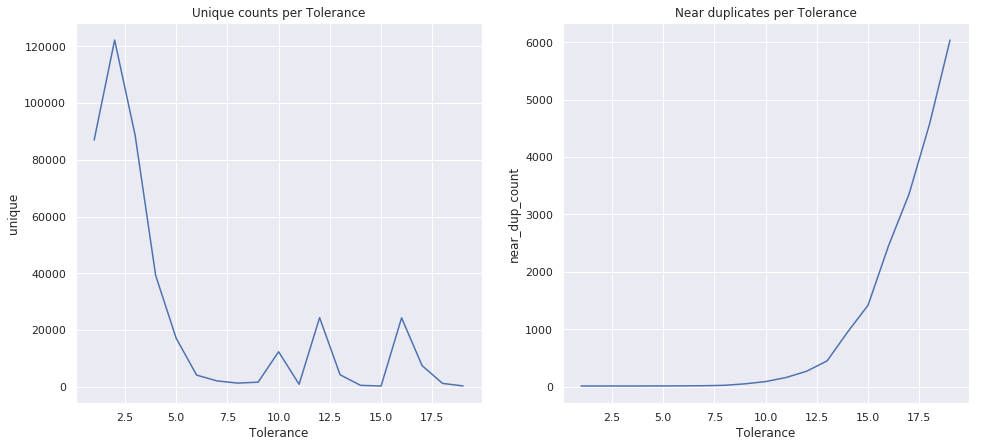

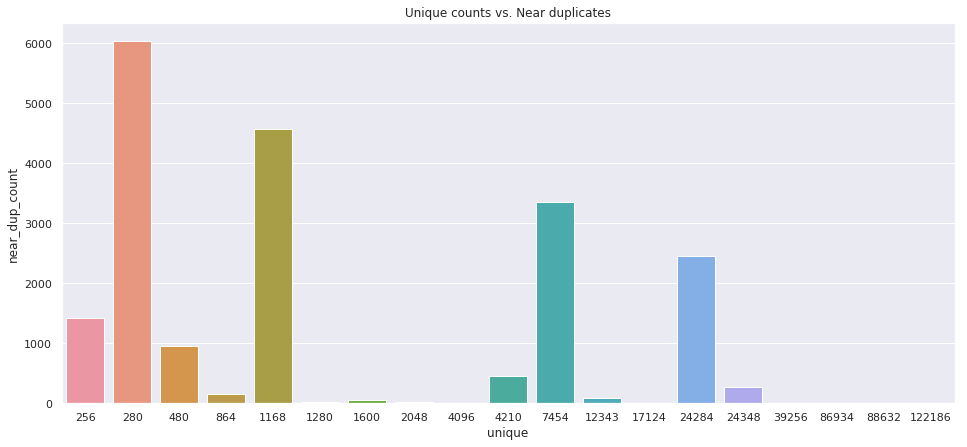

In [100]:
df_unique_simcount = pd.DataFrame(map_unique_simcount).T
f, ax = plt.subplots(1, 2, figsize=(16, 7))
g1 = sns.lineplot(x=df_unique_simcount.index, y="unique", data=df_unique_simcount, ax=ax[0])
t1 = g1.set_title("Unique counts per Tolerance")
x1 = g1.set_xlabel("Tolerance")

g2 = sns.lineplot(x=df_unique_simcount.index, y="near_dup_count", data=df_unique_simcount, ax=ax[1])
t2 = g2.set_title("Near duplicates per Tolerance")
x2 = g2.set_xlabel("Tolerance")

f, ax = plt.subplots(1, 1, figsize=(16, 7))
g = sns.barplot(y="near_dup_count", x="unique", data=df_unique_simcount)
t = g.set_title("Unique counts vs. Near duplicates")

### Build a histogram showing the overall distribution of “near-duplication”

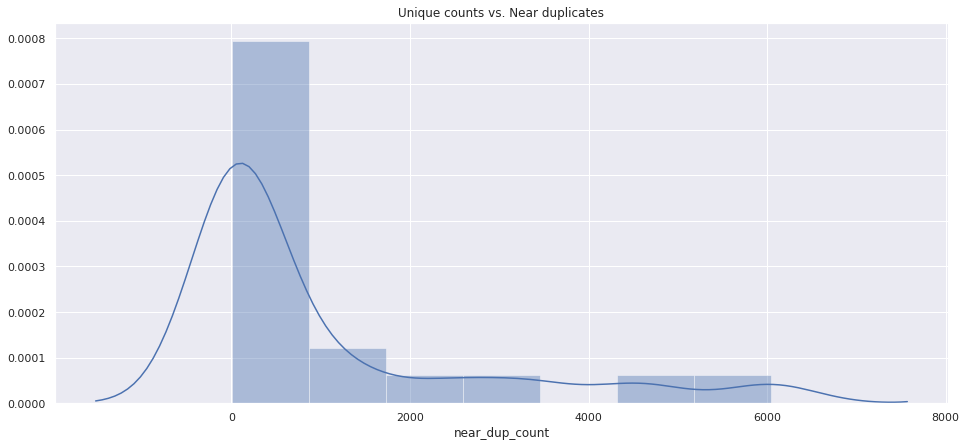

In [102]:
f, ax = plt.subplots(1, 1, figsize=(16, 7))
g = sns.distplot(a=df_unique_simcount["near_dup_count"])
t = g.set_title("Distribution of Near duplicates")